## Introduction

We would like to understand the governing principles behind the double descent (DD) phenomenon. Therefore we would like to construct the simplest possible environment capable of demonstrating the DD behavior. We will use linear regression. We must first create the machine learning problem which includes defining the data generating distribution, the model, and the loss function. The data generating distribution will be a straight line with homoskedastic noise. The model will be a polynomial of arbitrary order and the loss function will be the traditional SSE.

## The Data Generating Distribution

We will work backwards by first defining a relationship between random variables and then construct the resulting distribution. Let 

$$y=mx+\epsilon$$

where $X \sim U[0,1]$ ($p(x)=1$) and $\epsilon \sim \mathcal{N}(0,s^2)$ is the noise term. We immediately see that $y$ can be interpreted as the result of a reparameterization, thus given a particular observation $X=x$ the random variable $Y$ is also distributed normally $\mathcal{N}(mx,s^2)$ with the resulting pdf.

$$p(y|x) = \frac{1}{\sqrt{2\pi s^2}}\exp\bigg(-\frac{(y-mx)^2}{2 s^2}\bigg)$$

In this way, we can trivially define the joint pdf

$$p(x,y) = p(y|x)p(x) = p(y|x) = \frac{1}{\sqrt{2\pi s^2}}\exp\bigg(-\frac{(y-mx)^2}{2 s^2}\bigg)$$

---

We can create observations from $P(X,Y)$ via ancestral sampling, i.e. we first draw a sample  $x\sim p(x)$ and then use it to draw a sample $y \sim p(y|x)$ resulting in $(x,y) \sim P(X,Y)$. We create a simple interface for generating an arbtrary number of samples below.

In [1]:
import torch

class P():
    
    def __init__(self, m, s):
        
        self.m = m # Slope of line
        self.s = s # Standard deviation of injected noise
        
    def sample(self, size):
        
        x = torch.rand(size, dtype=torch.double)
        y = self.m*x + torch.randn(size, dtype=torch.double)*self.s
        return (x,y)

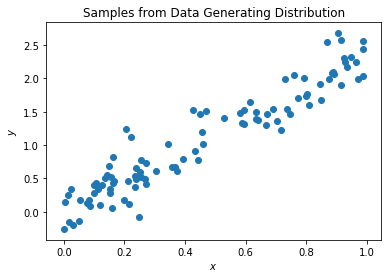

In [3]:
import matplotlib.pyplot as plt

p = P(2.3, 0.25)
(x_pts,y_pts) = p.sample(100)
plt.title("Samples from Data Generating Distribution")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(x_pts, y_pts)
plt.show()

## The Model

The double descent phenomena has been shown to take place with increasing capacity and training epochs. To easily explore this our model should have a convenient way to increase and decrease its capacity, i.e. roughly the degree of the polynomial. Below we create a very simple polynomial class where the order can be specified during construction of the object.

In [4]:
class Polynomial():
    
    def __init__(self, order):
        
        self.order = order
        self.params = torch.tensor(2*np.random.rand(order+1)-1, dtype=torch.double, requires_grad=True)
        
    def __call__(self, xvals, take_grad=True):
        
        if take_grad: # If take_grad is true, then take gradient
            xvals = torch.tensor(np.vander(xvals,self.order+1), dtype=torch.double)
            y_vals = xvals.mv(self.params)
        else:
            with torch.no_grad(): # Use this for plotting
                xvals = torch.tensor(np.vander(xvals,self.order+1), dtype=torch.double)
                y_vals = xvals.mv(self.params)
                
        return y_vals

We will check a few plots of various randomly initialized polynomials

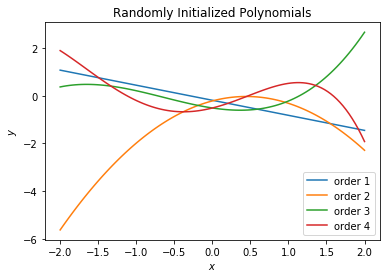

In [8]:
import numpy as np
xvals = np.linspace(-2,2,100)
for order in range(1,5):
    poly = Polynomial(order)
    yvals = poly(xvals, take_grad=False)
    plt.plot(xvals,yvals.detach().numpy(),label='order {}'.format(order))
plt.title("Randomly Initialized Polynomials")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

## The Loss Function

We will simply use the standard sum of squared errors loss function for regression here. However we will define our loss function as a functional to be consistent with traditional generalization theory. Therefore it will accept the model and the data as parameters.

In [9]:
def loss(model, data, take_grad=True):
    xvals, y_true = data
    y_pred = model(xvals, take_grad)
    return torch.pow(y_true-y_pred,2).mean()

## Sanity Check

Now we run through everything once and plot the results to help convince us that everything is working as expected. First we generate 10 points from a line with a slope of 3.4 and standard deviation of 0.3.

In [10]:
data = P(3.4,0.3).sample(20)

We start with the simplest model to visualize and check, a first order polynomial

In [11]:
poly = Polynomial(1)

If we plot both the line and the sampled points we should be able to eyeball the error

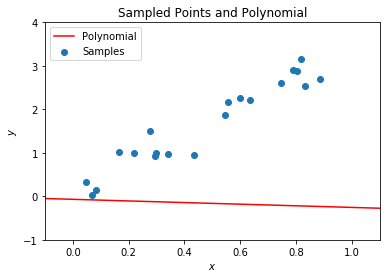

In [13]:
def create_plot(poly,data):
    plt.title("Sampled Points and Polynomial")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.scatter(data[0],data[1],label="Samples")
    xpts = np.linspace(-0.25,1.25,250)
    plt.plot(xpts,poly(xpts,take_grad=False).numpy(), c='r', label="Polynomial")
    plt.legend()
    plt.xlim(-0.1,1.1)
    plt.ylim(-1,4)
    plt.show()
create_plot(poly,data)

In [14]:
loss(poly,data,take_grad=False)

tensor(4.3252, dtype=torch.float64)

## Fit the Line to the Points

Now we simply fit the line to the points using traditional stochastic gradient descent (SGD)

In [23]:
l = loss(poly,data)
l.backward()
with torch.no_grad():
    poly.params -= 0.1*poly.params.grad

In the above code block we passed the entire dataset through in one batch, then updated the parameters accordingly, let us take a look at the line now to see if it improved at all.

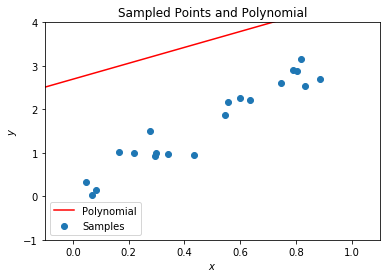

In [24]:
create_plot(poly,data)

## Fit to Convergence

Everything checks out, we now run a full example and iterate over many more samples to convergence

In [26]:
dataset_size = 20
epochs = 100
lr = 1e-1
p = P(2.583,0.27)
data = p.sample(dataset_size)
poly = Polynomial(1)

Let's create a plot a see where we are starting from

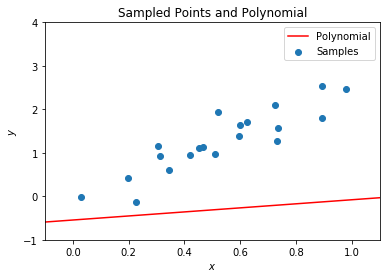

In [27]:
create_plot(poly,data)

In [36]:
for epoch in range(epochs):
    loss(poly,data).backward()
    with torch.no_grad():
        poly.params -= lr*poly.params.grad
        poly.params.grad.zero_()

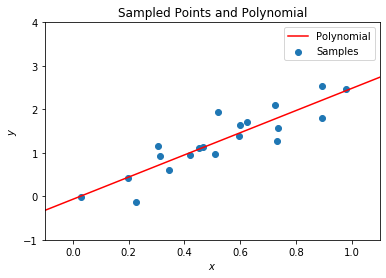

In [37]:
create_plot(poly,data)

## Higher Order Polynomials

Let's repeat the exact same experiment but with a quadratic rather than a straight line!

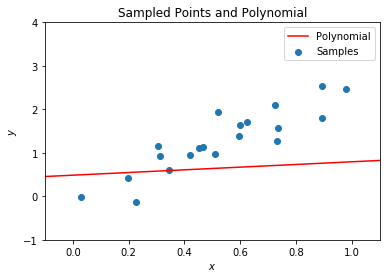

In [38]:
poly = Polynomial(2)
create_plot(poly,data)

In [39]:
for epoch in range(epochs):
    loss(poly,data).backward()
    with torch.no_grad():
        poly.params -= lr*poly.params.grad
        poly.params.grad.zero_()

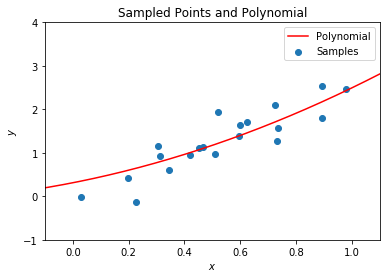

In [40]:
create_plot(poly,data)

## Double Descent

We now have a framework to try and reproduce the double descent phenomena. We will start with seeing if it happens with number of epochs. This must be done with a model that has many more parameters than necessary to ensure there is significant overfitting. Then after numerous epochs, we should begin to see the model enter the "Interpolation Regime". To appropriate observe the phenomenon we must measure both the training and the test loss as a function of the epochs.

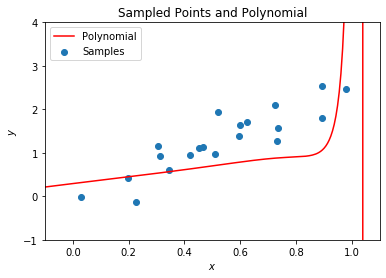

100%|██████████| 10000/10000 [00:21<00:00, 470.98it/s]


In [41]:
from tqdm import tqdm
epochs = int(1e4)
learning_rate = 1e-2
poly = Polynomial(1000)
create_plot(poly,data)
test_data = p.sample(100)
train_err = []
test_err = []
optimizer = torch.optim.Adam([poly.params], lr=learning_rate)
for epoch in tqdm(range(epochs)):
    train_loss = loss(poly,data)
    test_loss = loss(poly,test_data,take_grad=False)
    train_err.append(train_loss)
    test_err.append(test_loss)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

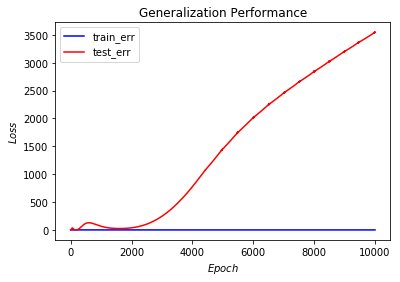

In [20]:
def plot_loss(train, test):
    plt.title("Generalization Performance")
    plt.xlabel("$Epoch$")
    plt.ylabel("$Loss$")
    plt.plot(train, c='b', label="train_err")
    plt.plot(test, c='r', label="test_err")
    plt.legend()
    plt.show()
plot_loss(train_err, test_err)

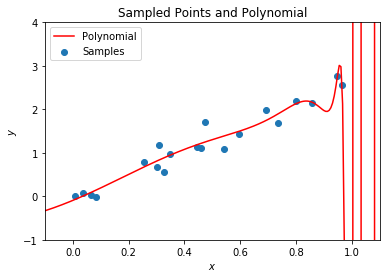

In [21]:
plt.title("Sampled Points and Polynomial")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(data[0],data[1],label="Samples")
xpts = np.linspace(-0.25,1.25,250)
plt.plot(xpts,poly(xpts,take_grad=False), c='r', label="Polynomial")
plt.legend()
plt.xlim(-0.1,1.1)
plt.ylim(-1,4)
plt.show()

In [61]:
order = 10
params = np.linalg.pinv(np.polynomial.legendre.legvander(data[0],order)).dot(data[1])
params = params*np.sqrt(2*np.arange(0, params.shape[1], 1)+1)

IndexError: tuple index out of range

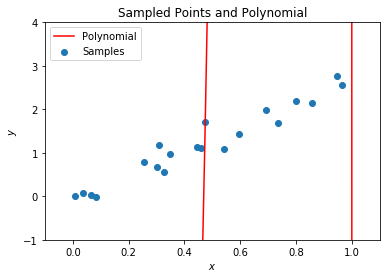

In [62]:
plt.title("Sampled Points and Polynomial")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(data[0],data[1],label="Samples")
xpts = np.linspace(-0.25,1.25,250)
plt.plot(xpts,np.vander(xpts, order+1).dot(params), c='r', label="Polynomial")
plt.legend()
plt.xlim(-0.1,1.1)
plt.ylim(-1,4)
plt.show()

In [58]:
params.shape

(3001,)